In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
sys.path.append("/scratch/izar/kapps/DEX-Cyclic-Arbitrage/")
from config.get import cfg
# from tensorflow import keras
# from tensorflow.keras import layers
import autoencoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the data

In [5]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(2729, 3, 600, 2),X_test=(682, 3, 600, 2)


# Loading the model

In [6]:
model_name , autoencoder = autoencoders.linear_simple()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 600, 2)]       0         
                                                                 
 reshape (Reshape)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 100)               360100    
                                                                 
 dense_1 (Dense)             (None, 3600)              363600    
                                                                 
 reshape_1 (Reshape)         (None, 3, 600, 2)         0         
                                                                 
Total params: 723,700
Trainable params: 723,700
Non-trainable params: 0
_________________________________________________________________


2022-01-05 11:29:16.185379: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-05 11:29:16.185430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (izar): /proc/driver/nvidia/version does not exist
2022-01-05 11:29:16.186552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training 

In [7]:
hist = autoencoder.fit(X_train, X_train,epochs=100)

Epoch 1/100
86/86 [==============================] - 3s 28ms/step - loss: 0.4491
Epoch 2/100
86/86 [==============================] - 2s 25ms/step - loss: 0.2138
Epoch 3/100
86/86 [==============================] - 2s 25ms/step - loss: 0.1700
Epoch 4/100
86/86 [==============================] - 2s 25ms/step - loss: 0.1488
Epoch 5/100
86/86 [==============================] - 2s 25ms/step - loss: 0.1363
Epoch 6/100
86/86 [==============================] - 2s 25ms/step - loss: 0.1289
Epoch 7/100
86/86 [==============================] - 2s 26ms/step - loss: 0.1215
Epoch 8/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1178
Epoch 9/100
86/86 [==============================] - 2s 27ms/step - loss: 0.1163
Epoch 10/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1144
Epoch 11/100
86/86 [==============================] - 2s 28ms/step - loss: 0.1135
Epoch 12/100
86/86 [==============================] - 2s 25ms/step - loss: 0.1130
Epoch 13/100
86/86 [=====

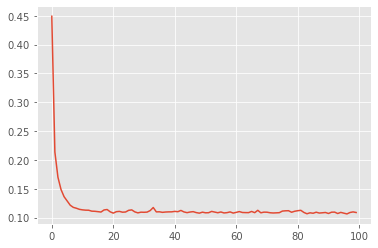

In [10]:
plt.plot(hist.history["loss"])
plt.show()

# Testing

In [12]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

# Comparison with PCA


In [15]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=100)
N_train = len(X_train)
N_test  = len(X_test)
tX_train = X_train.reshape(N_train,-1)
tX_test = X_test.reshape(N_test,-1)
pca.fit(tX_train)
pca_train = mean_squared_error(tX_train, pca.inverse_transform(pca.transform(tX_train)))
pca_test =  mean_squared_error(tX_test, pca.inverse_transform(pca.transform(tX_test)))
print(f"MSE train : {pca_train} \nMSE test  : {pca_test}")

MSE train : 0.09567407162445486 
MSE test  : 0.10245050102308027
